# COOKIE CATS A/B TEST

## Target Metric: 

### sum_gamerounds
    The total number of game rounds played by a user in the first 14 days after installation.

### Why this Metric?

1. Directly Measures Engagement:
    * A higher number of game rounds indicates that players are more engaged with the game.
    * Engagement is a key goal for game developers, as it often leads to increased player retention and revenue.

2. Measurable and Comparable:
    * sum_gamerounds is a continuous numeric variable, making it ideal for comparisons between the gate_30 and gate_40 groups.
    * This metric captures the immediate impact of moving the gate in the game.

3. Aligned with Test Goal:
    * The stated goal of the test is to determine whether moving the first gate from level 30 to level 40 affects player engagement.
    * By analyzing the total rounds played, we can infer whether the gate placement positively or negatively impacts player behavior

### How it Measures Progress 

- Comparison Between Groups:
    * By comparing the mean number of game rounds played (sum_gamerounds) between the control (gate_30) and treatment (gate_40) groups, we can assess the impact of the gate change.

- Long-Term Impact:
    * If the treatment group (gate_40) shows significantly higher sum_gamerounds, it suggests the gate change positively influences player engagement.

- Complementary Metrics:
    * While sum_gamerounds is the primary metric, we can use retention rates (retention_1 and retention_7) as secondary metrics to validate the results.

In [1]:
import pandas as pd
from scipy.stats import chisquare
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [2]:
file_path = "cookie_cats.csv" 
data = pd.read_csv(file_path)

print(data.info())
data.head(8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False


## Sample size and Variant Proportions

In [3]:
sample_size = data["version"].value_counts()
print("Sample Size per Variant:")
print(sample_size)


variant_proportions = data["version"].value_counts(normalize=True) * 100
print("\nVariant Proportions (%):")
print(variant_proportions)

Sample Size per Variant:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Variant Proportions (%):
version
gate_40    50.437415
gate_30    49.562585
Name: proportion, dtype: float64


The sample sizes are relatively balanced between the two variants. While there is a slight difference, such variations are expected in randomized experiments due to natural randomness during user allocation. 

The proportions are very close to the ideal 50%-50% split, suggesting that the randomization process worked as intended. This slight deviation (0.88 percentage points) is not statistically concerning.

## SRM Detection

In [4]:
observed_counts = data["version"].value_counts()

expected_counts = [len(data) / 2] * 2  # Assuming 50-50 split

chi2_stat, p_val = chisquare(f_obs=observed_counts, f_exp=expected_counts)

print(f"Chi-Square Test for SRM:")
print(f"Chi2 Statistic = {chi2_stat:.4f}, P-value = {p_val:.4f}")

if p_val < 0.05:
    print("Sample Ratio Mismatch detected. Investigate further before proceeding.")
else:
    print("No Sample Ratio Mismatch detected. Proceed with the analysis.")

Chi-Square Test for SRM:
Chi2 Statistic = 6.9024, P-value = 0.0086
Sample Ratio Mismatch detected. Investigate further before proceeding.


### Assessing the impact of Sample Ratio Mismatch

#### Comparing Key Metrics Across Groups

Proportion of Players in Each Engagement Segment:
engagement_segment      high       low  moderate
version                                         
gate_30             0.001186  0.862013  0.136801
gate_40             0.001385  0.860450  0.138165


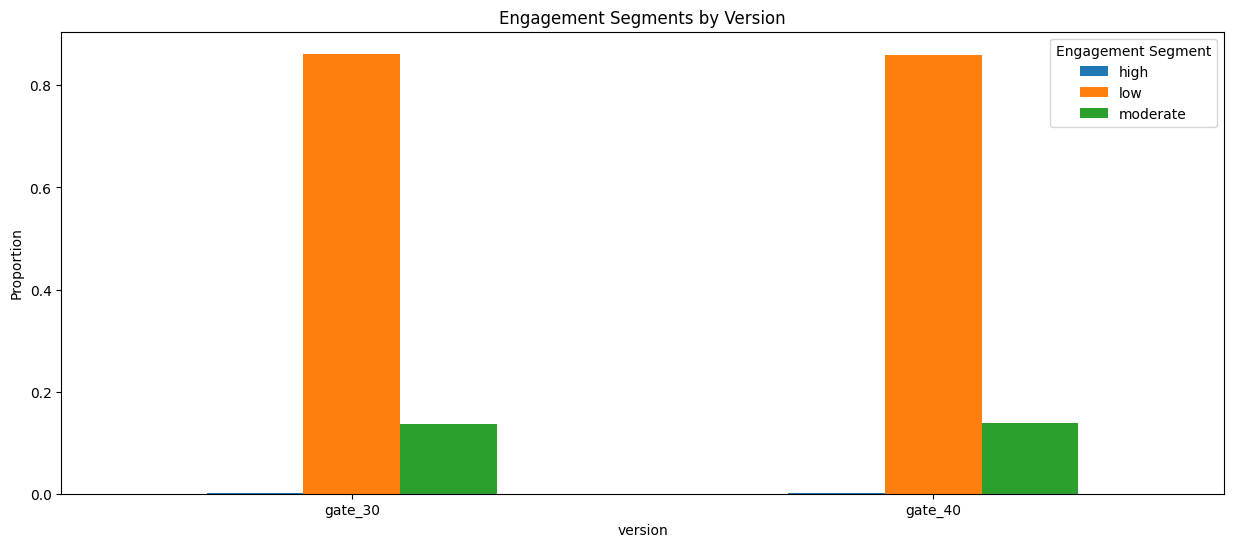

In [5]:
'''Create engagement segments'''

def engagement_segment(rounds):
    if rounds < 100:
        return "low"
    elif rounds <= 1000:
        return "moderate"
    else:
        return "high"

data["engagement_segment"] = data["sum_gamerounds"].apply(engagement_segment)

segment_proportions = data.groupby(["version", "engagement_segment"]).size().unstack()
segment_proportions = segment_proportions.div(segment_proportions.sum(axis=1), axis=0)

print("Proportion of Players in Each Engagement Segment:")
print(segment_proportions)

segment_proportions.plot(
    kind="bar",
    figsize=(15, 6),
    title="Engagement Segments by Version",
    ylabel="Proportion",
)
plt.xticks(rotation=0)
plt.legend(title="Engagement Segment")
plt.show()

**Proportion or Players in Each Engagement Segment** 

    Low Engagement (fewer than 100 rounds)
        - gate_30: 86.20%
        - gate_40: 86.05%
        - The majority of players fall into this category for both groups, and the proportions are nearly identical. This indicates no significant impact of SRM in this segment.
    
    Moderate Engagement (100 - 1000 rounds)
        - Similar proportions are observed, suggesting SRM has minimal impact on this group as well.
    
    High Engagement ( more than 1000 rounds)
        - gate_30: 0.12%
        - gate_40: 0.14%
        - While both groups have a tiny proportion of highly engaged players, gate_40 has a slightly higher percentage in this segment.

**Conclusion: The proportions across engagement segments are consistent between gate_30 and gate_40. SRM is unlikely to cause bias in terms of the distribution of engagement levels.**

## Metric Comparison for A/B Test

Retention Rates by Engagement Segment:
                            retention_1  retention_7
version engagement_segment                          
gate_30 high                   0.943396     1.000000
        low                    0.375532     0.106768
        moderate               0.901717     0.708913
gate_40 high                   0.968254     0.968254
        low                    0.368335     0.096318
        moderate               0.897534     0.707717

Engagement Stats by Segment:
                                   mean          std  count
version engagement_segment                                 
gate_30 high                2268.358491  6673.198198     53
        low                   21.486401    23.252602  38532
        moderate             228.398692   141.747253   6115
gate_40 high                1326.952381   344.664139     63
        low                   21.317289    23.626467  39141
        moderate             225.227049   142.888271   6285


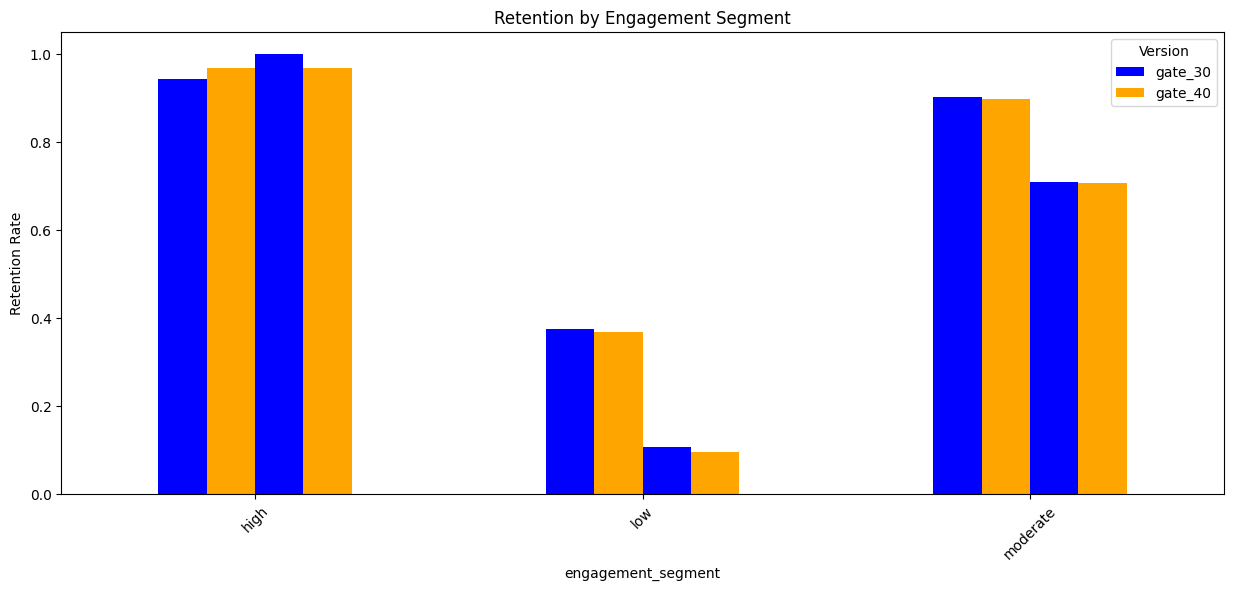

In [6]:
retention_segment = data.groupby(["version", "engagement_segment"])[
    ["retention_1", "retention_7"]
].mean()
print("Retention Rates by Engagement Segment:")
print(retention_segment)


engagement_stats_segment = data.groupby(["version", "engagement_segment"])[
    "sum_gamerounds"
].agg(["mean", "std", "count"])
print("\nEngagement Stats by Segment:")
print(engagement_stats_segment)

retention_segment.unstack(level=0).plot(
    kind="bar",
    figsize=(15, 6),
    color=["blue", "orange"],
    title="Retention by Engagement Segment",
    ylabel="Retention Rate",
)
plt.xticks(rotation=45)
plt.legend(["gate_30", "gate_40"], title="Version")
plt.show()

**Retention vs Engagement**

* **High Engagement**

    Players in gate_30 have significantly higher average rounds (2,268.36) compared to gate_40 (1,326.95). This shows that moving the gate to level 40 reduces the maximum potential engagement of highly active players.
    - *Day 1 Retention:* Both groups have extremely high retention rates (over 94%), with gate_40 slightly higher at 96.8%.

    - *Day 7 Retention:* gate_30 shows perfect retention (100%), while gate_40 has 96.8%.
    - This suggests that highly engaged players are slightly more likely to stay with gate_30.
* **Moderate Engagement**

    Average game rounds are nearly identical between groups (gate_30: 228.40 vs. gate_40: 225.23).
    - *Day 1 Retention:*
        - gate_30: 90.17% 
        - gate_40: 89.75%
        - Retention rates are very similar for this group.
    - *Day 7 Retention:*
        - gate_30: 70.89%
        - gate_40: 70.77%
        - Both groups retain players at nearly identical levels.
* **Low Engagement**

    Both groups exhibit similar averages (gate_30: 21.49 vs. gate_40: 21.32), showing no meaningful difference.
    - *Day 1 Retention:*
        - gate_30: 37.55%
        - gate_40: 36.83%
        - Slightly higher for gate_30.
    - *Day 7 Retention:*
        - gate_30: 10.68%
        - gate_40: 9.63%
        - gate_30 performs better, retaining more low-engagement players longer.

**Conclusion**
- Retention rates favor gate_30, particularly for low-engagement players. This may suggest that keeping the gate at level 30 provides a better user experience for less engaged players.
- High engagement players are more significantly affected by the gate change. Moving the gate to level 40 reduces their engagement potential.

## Statistical Tests

### Engagement: `sum_gamerounds`

In [7]:
gate_30 = data[data["version"] == "gate_30"]["sum_gamerounds"]
gate_40 = data[data["version"] == "gate_40"]["sum_gamerounds"]

t_stat, p_val = ttest_ind(gate_30, gate_40, equal_var=False)
print(f"T-Test for sum_gamerounds: T-stat = {t_stat:.4f}, P-value = {p_val:.4f}")

T-Test for sum_gamerounds: T-stat = 0.8854, P-value = 0.3759


- The p-value indicates no statistically significant difference in the mean number of game rounds played between the gate_30 and gate_40 groups.

- The gate placement (at level 30 vs. level 40) does not appear to have a meaningful effect on overall player engagement as measured by sum_gamerounds.

### Retention: `retention_1` and `retention_7` 

In [8]:
retention_1_success = data.groupby("version")["retention_1"].sum()
retention_1_total = data.groupby("version")["retention_1"].count()
z_stat_1, p_val_1 = proportions_ztest(count=retention_1_success, nobs=retention_1_total)
print(f"Z-Test for Retention Day 1: Z-stat = {z_stat_1:.4f}, P-value = {p_val_1:.4f}")


retention_7_success = data.groupby("version")["retention_7"].sum()
retention_7_total = data.groupby("version")["retention_7"].count()
z_stat_7, p_val_7 = proportions_ztest(count=retention_7_success, nobs=retention_7_total)
print(f"Z-Test for Retention Day 7: Z-stat = {z_stat_7:.4f}, P-value = {p_val_7:.4f}")

Z-Test for Retention Day 1: Z-stat = 1.7841, P-value = 0.0744
Z-Test for Retention Day 7: Z-stat = 3.1644, P-value = 0.0016


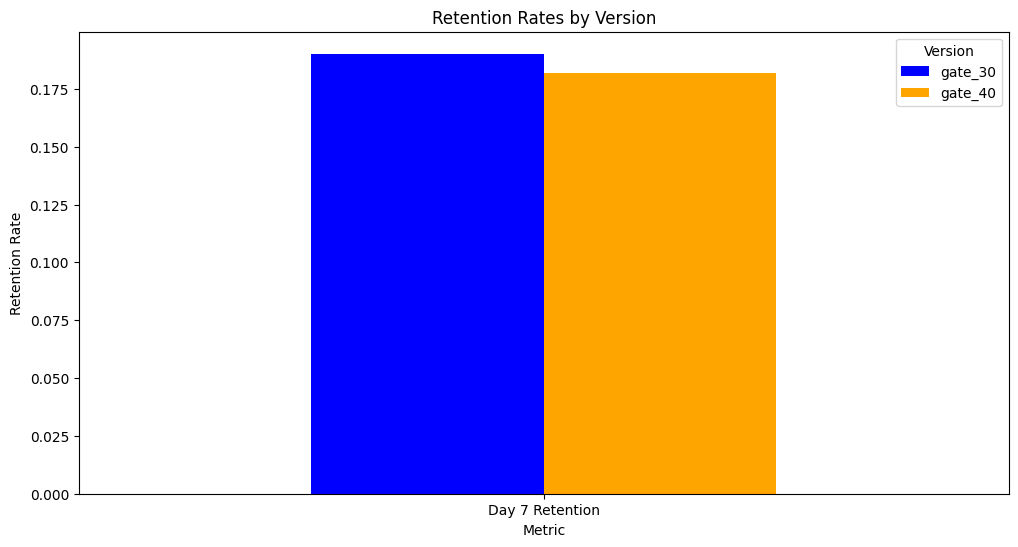

In [9]:

retention_7_rates = data.groupby("version")["retention_7"].mean()
retention_rates = pd.DataFrame(
    {
        "Metric": ["Day 7 Retention"],
        "gate_30": [retention_7_rates["gate_30"]],
        "gate_40": [retention_7_rates["gate_40"]],
    }
)

retention_rates.set_index("Metric").plot(
    kind="bar", figsize=(12, 6), color=["blue", "orange"]
)
plt.title("Retention Rates by Version")
plt.ylabel("Retention Rate")
plt.xticks(rotation=0)
plt.legend(title="Version")
plt.show()

**Retention**
- **Day 1 (`retention_1`):**
    - The p-value is slightly above the conventional significance threshold of 0.05, meaning the difference in Day 1 retention rates between the two groups is not statistically significant at the 5% level.
    
    - **For Short-Term Retention:**  While the difference in Day 1 retention rates is not statistically significant, there is a trend favoring gate_30. It may be worth investigating further with additional data or analysis

- **Day 7 (`retention_7`) :**
    - The p-value indicates a statistically significant difference in Day 7 retention rates between the two groups.
    - gate_30 has a higher retention rate than gate_40 on Day 7. This suggests that keeping the gate at level 30 improves longer-term player retention compared to moving it to level 40 potentially.

## Treatment Effect and Confidence Interval

In [10]:

retention_7_gate_30 = data[data["version"] == "gate_30"]["retention_7"]
retention_7_gate_40 = data[data["version"] == "gate_40"]["retention_7"]

treatment_effect = retention_7_gate_30.mean() - retention_7_gate_40.mean()

n_30 = len(retention_7_gate_30)
n_40 = len(retention_7_gate_40)
std_30 = retention_7_gate_30.std()
std_40 = retention_7_gate_40.std()

se_diff = np.sqrt((std_30**2 / n_30) + (std_40**2 / n_40))
ci_low_analytical = treatment_effect - 1.96 * se_diff
ci_high_analytical = treatment_effect + 1.96 * se_diff

print(f"Treatment Effect (Day 7 Retention): {treatment_effect:.4f}")
print(
    f"Analytical Confidence Interval: ({ci_low_analytical:.4f}, {ci_high_analytical:.4f})"
)

Treatment Effect (Day 7 Retention): 0.0082
Analytical Confidence Interval: (0.0031, 0.0133)


- Players in the **treatment group (`gate_40`)** had a **0.82% higher retention rate on Day 7** compared to the control group (`gate_30`). This is a small but positive effect, suggesting that moving the gate to level 40 slightly improves long-term player retention.

- Since the confidence interval is entirely positive (does not include 0), the effect is statistically significant. This reinforces that the treatment group (`gate_40`) performs better than the control group (`gate_30`).

### Bootstrap Confidence Interval 

In [11]:
n_boot = 10000
boot_diffs = []

for _ in range(n_boot):
    boot_30 = np.random.choice(retention_7_gate_30, size=n_30, replace=True)
    boot_40 = np.random.choice(retention_7_gate_40, size=n_40, replace=True)
    boot_diffs.append(boot_30.mean() - boot_40.mean())

ci_low_bootstrap, ci_high_bootstrap = np.percentile(boot_diffs, [2.5, 97.5])

print(
    f"Bootstrap Confidence Interval: ({ci_low_bootstrap:.4f}, {ci_high_bootstrap:.4f})"
)

Bootstrap Confidence Interval: (0.0030, 0.0133)


- The treatment effect and both confidence intervals suggest that moving the gate to level 40 **slightly improves Day 7 retention.**

- While the improvement (0.82%) is relatively small, it could be meaningful depending on the game's business objectives (e.g., monetization, player lifetime value).

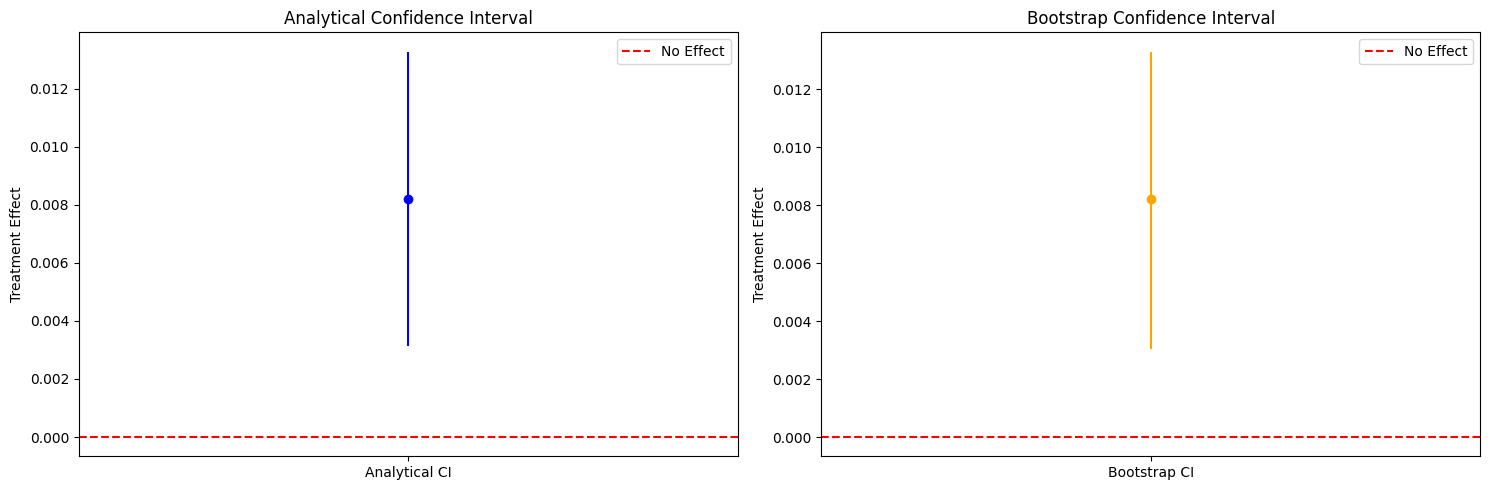

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].errorbar(
    x=["Analytical CI"],
    y=[treatment_effect],
    yerr=[
        [treatment_effect - ci_low_analytical],
        [ci_high_analytical - treatment_effect],
    ],
    fmt="o",
    color="blue",
)
axes[0].axhline(0, color="red", linestyle="--", label="No Effect")
axes[0].set_title("Analytical Confidence Interval")
axes[0].set_ylabel("Treatment Effect")
axes[0].legend()


axes[1].errorbar(
    x=["Bootstrap CI"],
    y=[treatment_effect],
    yerr=[
        [treatment_effect - ci_low_bootstrap],
        [ci_high_bootstrap - treatment_effect],
    ],
    fmt="o",
    color="orange",
)
axes[1].axhline(0, color="red", linestyle="--", label="No Effect")
axes[1].set_title("Bootstrap Confidence Interval")
axes[1].set_ylabel("Treatment Effect")
axes[1].legend()

plt.tight_layout()
plt.show()

- Both confidence intervals are above zero, indicating that the treatment effect is statistically significant.

- The analytical CI and bootstrap CI are very close, reinforcing the robustness of the estimate

## Overall Recommendations 

1. **Retention Impact:**
    - If retention is a key performance indicator, this result supports moving the gate to level 40 to slightly improve long-term retention.

2. **Decision-Making:**
    - The statistical significance indicates confidence in the result.

    - However, the small magnitude of the treatment effect (0.82%) should be weighed against other factors, such as the impact on player engagement or player satisfaction.

3. **Further Consideration:**
    - Explore whether this slight improvement in Day 7 retention translates into higher revenue or lifetime value for players.

    - If engagement (game rounds played) or player experience are also key goals, the potential trade-offs of moving the gate to level 40 should be carefully assessed.